In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import gc
import warnings
import collections
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve,\
                            roc_auc_score,\
                            precision_score, \
                            recall_score,\
                            accuracy_score, \
                            f1_score, \
                            confusion_matrix, \
                            auc, \
                            classification_report, \
                            plot_confusion_matrix,\
                            plot_roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


## I. DATA PROCESSING

In [ ]:
def delete_high_corre(data: pd.DataFrame, p):
    corr = data.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > p)]
    return drop_list


def percent_null(data):
    x = data.isnull().sum()
    count = len(data)
    x = pd.DataFrame(x, columns=['number_null'])
    x['percent'] = round((x['number_null'] / count) * 100, 2)
    return x

def make_corr(Vs, df, Vtitle=""):
    cols = ['isfraud'] + Vs
    plt.figure(figsize=(15, 15))
    sns.heatmap(df[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle != '':
        plt.title(Vtitle, fontsize=14)
    else:
        plt.title(Vs[0] + ' - ' + Vs[-1], fontsize=14)
    plt.show()

    #  phân cụm data 'V' theo các nhóm chứa số lượng giá trị NaN


def v_processing_op_2(df):
    v_columns = [col for col in df if col[0] == 'v']
    nans_groups = {}
    for col in v_columns:
        cur_group = df[col].isna().sum()
        try:
            nans_groups[cur_group].append(col)
        except:
            nans_groups[cur_group] = [col]
    for i, j in nans_groups.items():
        print(i)
        a = make_corr(nans_groups[i], df)
    return a

def reduce_group(dataframe, group, c="v"):
    use = []
    for g in group:
        mx = 0
        vx = g[0]
        for j in g:
            n = dataframe[c + str(j)].nunique()
            if n > mx:
                mx = n
                vx = j
        use.append(vx)
    m = 0
    while m < len(group):
        for i in group[m]:
            if i not in use:
                del dataframe['v' + str(i)]
        m += 1
    return dataframe


class Fraud_detection:
    def __init__(self, df):
        self._df = df

    def read_data(self):
        self._df.columns = [col.lower() for col in self._df.columns]
        self._df = self._df.drop_duplicates()
        return self._df

    def delete_null_over_p(self, p):
        x = percent_null(self._df)
        for i, j in zip(x['percent'], x.index):
            if i > p:
                del self._df[j]
        return self._df

    def delete_var_less_p(self, p):
        cat = [i for i in self._df.columns if self._df[i].dtypes != 'object']
        variance = self._df[cat].var(axis=0, skipna=True)
        variance = pd.DataFrame(variance, columns=['var'])
        for i, j in zip(variance.index, variance['var']):
            if j < p:
                del self._df[i]
        return self._df

    def time_transaction(self):
        del self._df['transactiondt']
        # D1 - D15:
        column_d = [col for col in self._df if col[0] == 'd'] + ['isfraud']
        drop_list_d = delete_high_corre(self._df[column_d], p=0.85)
        for i in drop_list_d:
            del self._df[i]
            column_d.remove(i)
        self._df[column_d] = self._df[column_d].fillna(self._df[column_d].mode().iloc[0])
        return self._df

    def cleaning_personal_info(self):
        self._df['productcd'] = self._df['productcd'].replace({'W': 1, 'H': 2, 'C': 3, 'S': 4, 'R': 5})
        del self._df['p_emaildomain']
        del self._df['r_emaildomain']
        return self._df

    def cleaning_distance(self):
        del self._df['addr1']
        del self._df['addr2']
        self._df['dist1'] = self._df['dist1'].fillna(self._df['dist1'].mean())
        return self._df

    def credit_card(self):
        # M1-M9
        column_m = [col for col in self._df.columns if 'm' in col]
        self._df[column_m] = self._df[column_m].fillna(self._df[column_m].mode().iloc[0])
        self._df[column_m] = self._df[column_m].replace({'T': 1, 'F': 0})
        self._df['m4'] = self._df['m4'].replace({'M0': 0, 'M1': 1, 'M2': 2})

        # Card1- card6
        self._df['card4'] = self._df['card4'].fillna(self._df['card4'].mode()[0])
        self._df['card4'] = self._df['card4'].replace(
            {'visa': 1, 'mastercard': 2, 'american express': 3, 'discover': 4})
        self._df = self._df.drop(['card1', 'card2', 'card3', 'card5', 'card6'], axis=1)

        # C1 - C14: delete by null and correlation_high
        c_col = [col for col in self._df if col[0] == 'c'] + ["isfraud"]
        drop_list_c = delete_high_corre(self._df[c_col], p=0.85)
        for i in drop_list_c:
            del self._df[i]
            c_col.remove(i)
        return self._df

    # option1

    def pca_v_processing(self):
        v_columns = [col for col in self._df if col[0] == 'v']
        self._df[v_columns] = self._df[v_columns].fillna(-1)
        pca = PCA(n_components=0.85)
        pca.fit(self._df[v_columns])
        pca_v_data = pca.transform(self._df[v_columns])
        pca_v_data = pd.DataFrame(data=pca_v_data).add_prefix('pca_V')
        self._df = pd.concat([self._df, pca_v_data], ignore_index=False, sort=False, axis=1)
        self._df.drop(v_columns, axis=1, inplace=True)
        del pca_v_data
        return self._df

    # option2

    def v_column(self):
        col_v = [col for col in self._df.columns if col[0] == 'v']
        #  a = v_processing_op_2
        self._df = reduce_group(self._df, group=[[2, 3], [4, 5], [6, 7, 8, 9], [10, 11]])
        self._df = reduce_group(self._df,
                                [[12, 13], [15, 16, 17, 18, 21, 22, 31, 32, 33, 34], [19, 20], [23, 24], [25, 26],
                                 [29, 30]])
        self._df = reduce_group(self._df,
                                [[35, 36], [37, 38, 39, 40], [42, 43, 50, 51, 52], [44, 45], [46, 47], [48, 49]])
        self._df = reduce_group(self._df,
                                [[53, 54], [55, 56], [57, 58, 59, 60, 63, 64, 71, 72, 73, 74], [61, 62], [66, 67],
                                 [69, 70]])
        self._df = reduce_group(self._df,
                                [[75, 76], [77, 78], [79, 80, 81, 84, 85, 92, 93, 94], [82, 83], [86, 87], [90, 91]])
        self._df = reduce_group(self._df, [[95, 96, 97, 101, 102, 103, 104, 105, 106], [98], [99, 100], \
                                           [109, 114], [115, 116],
                                           [123], [124, 125], [126, 127, 128, 132, 133, 134], [129, 130, 131, 135],
                                           [136, 137]])
        self._df = reduce_group(self._df,
                                [[138], [139, 140], [141, 142], [146, 147], [148, 149, 153, 154, 156, 157, 158],
                                 [161, 162, 163]])
        self._df = reduce_group(self._df, [[143, 164, 165], [144, 145, 150, 151, 152, 159, 160], [166]])
        self._df = reduce_group(self._df, [[167, 168, 177, 178, 179], [172, 176], [173], [181, 182, 183],
                                           [186, 187, 190, 191, 192, 193, 196, 199], [202, 203, 204, 211, 212, 213],
                                           [205, 206], [207], [214, 215, 216]])
        self._df = reduce_group(self._df,
                                [[169], [170, 171, 200, 201], [174, 175], [180], [184, 185], [188, 189],
                                 [194, 195, 197, 198],
                                 [208, 210], [209]])
        self._df = reduce_group(self._df,
                                [[217, 218, 219, 231, 232, 233, 236, 237], [223], [224, 225], [226], [228], [229, 230],
                                 [235], [242, 243, 244, 258], [246, 257], [247, 248, 249, 253, 254], [252], [260],
                                 [261, 262], [263, 265, 264], [266, 269], [267, 268], [273, 274, 275], [276, 277, 278]])
        self._df = reduce_group(self._df,
                                [[220], [221, 222, 227, 245, 255, 256, 259], [234], [238, 239], [250, 251],
                                 [270, 271, 272]])
        self._df = reduce_group(self._df,
                                [[279, 280, 293, 294, 295, 298, 299], [284], [285, 287], [286], [290, 291, 292], [297]])
        self._df = reduce_group(self._df, [[302, 303, 304], [306, 307, 308, 316, 317, 318], [309, 311], [310, 312],
                                           [319, 320, 321]])
        self._df = reduce_group(self._df, [[281], [282, 283], [288, 289], [296], [300, 301], [313, 314, 315]])
        self._df = reduce_group(self._df,
                                [[322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333], [325], [334, 335, 336],
                                 [337, 338, 339]])

        col_v_new = [col for col in self._df.columns if col[0] == 'v']
        drop_list_v = delete_high_corre(self._df[col_v_new], p=0.85)
        for v in drop_list_v:
            del self._df[v]
            col_v_new.remove(v)
        #  fill missing
        self._df[col_v_new] = self._df[col_v_new].fillna(self._df[col_v_new].mode().iloc[0])
        return self._df

    def processing_i(self):
        col_i = [col for col in self._df.columns if col[0] == 'i']
        num_id = [i for i in col_i if self._df[i].dtypes != "object"]
        num_id.remove("isfraud")
        cat_id = [j for j in col_i if self._df[j].dtypes == "object"]
        cat_id.append('devicetype')
        cat_id.append('deviceinfo')
        list_drop_i = delete_high_corre(self._df[num_id], p=0.85)
        for i in list_drop_i:
            del self._df[i]
        id_num_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06']
        for col in id_num_cols:
            self._df[col].fillna(self._df[col].min() - 10, inplace=True)
        id_num = ['id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_32']
        for col in id_num:
            self._df[col].fillna(self._df[col].min() - 100, inplace=True)

        #  category:
        for i in cat_id:
            if self._df[i].isna().sum() >= 446307:
                del self._df[i]
        one_hot = ['devicetype']
        del self._df['deviceinfo']
        self._df = pd.get_dummies(self._df, columns=one_hot)
        return self._df

In [ ]:
train_identity = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Essay /train_identity.csv",sep = ',')
train_transaction = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Essay /train_transaction.csv",sep = ',')
df_merge = pd.merge(train_transaction, train_identity, on = "TransactionID", how = "left")
df_merge_1 = df_merge

In [ ]:
detect = Fraud_detection(df_merge)
df = detect.read_data()
df = detect.delete_null_over_p(p=90)
df = detect.delete_var_less_p(p=0.01)
df = detect.time_transaction()
df = detect.cleaning_personal_info()
df = detect.cleaning_distance()
df = detect.credit_card()
df = detect.processing_i()
df2 = detect.pca_v_processing()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


279287


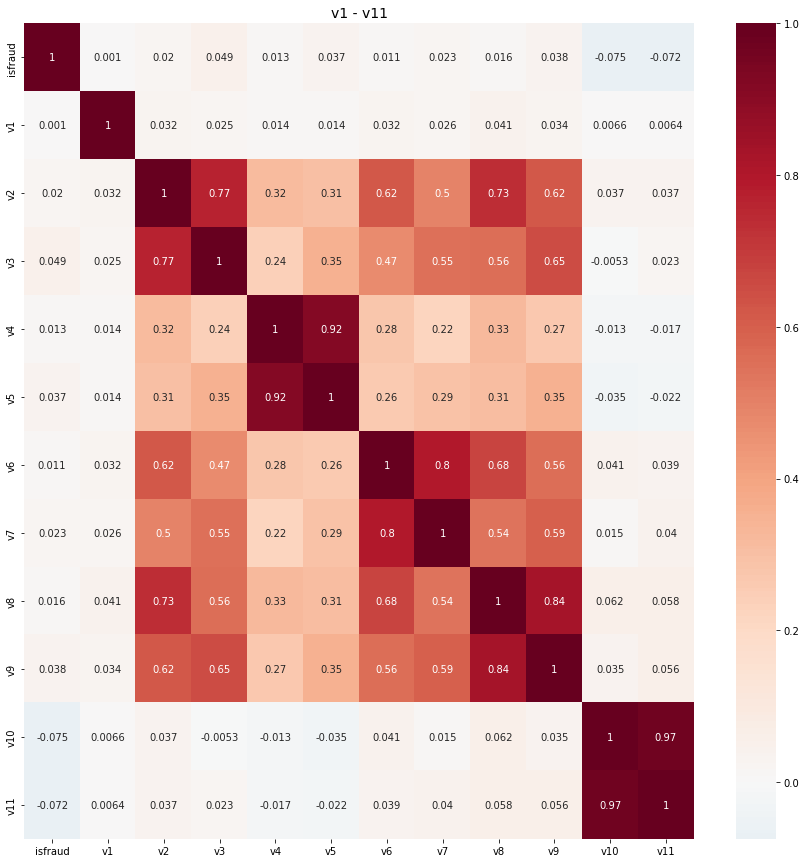

76073


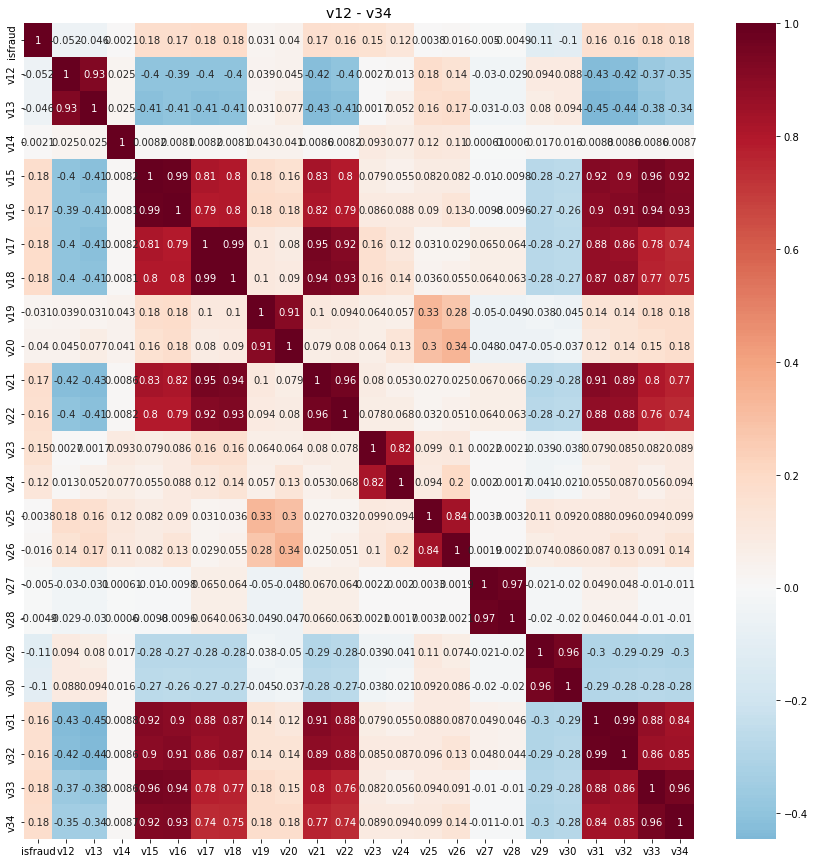

168969


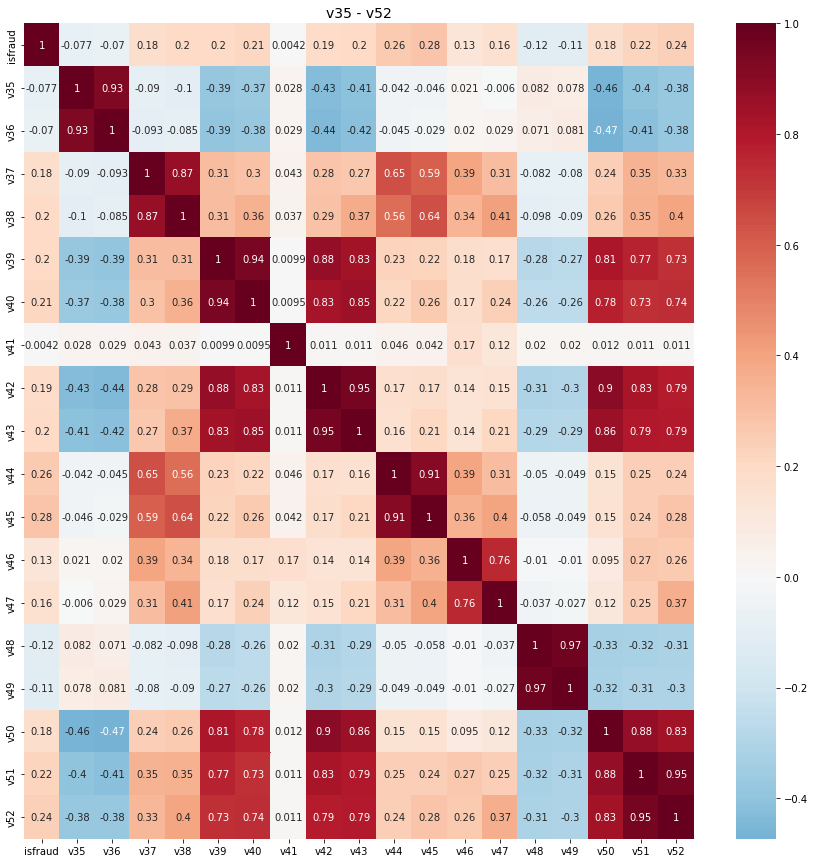

77096


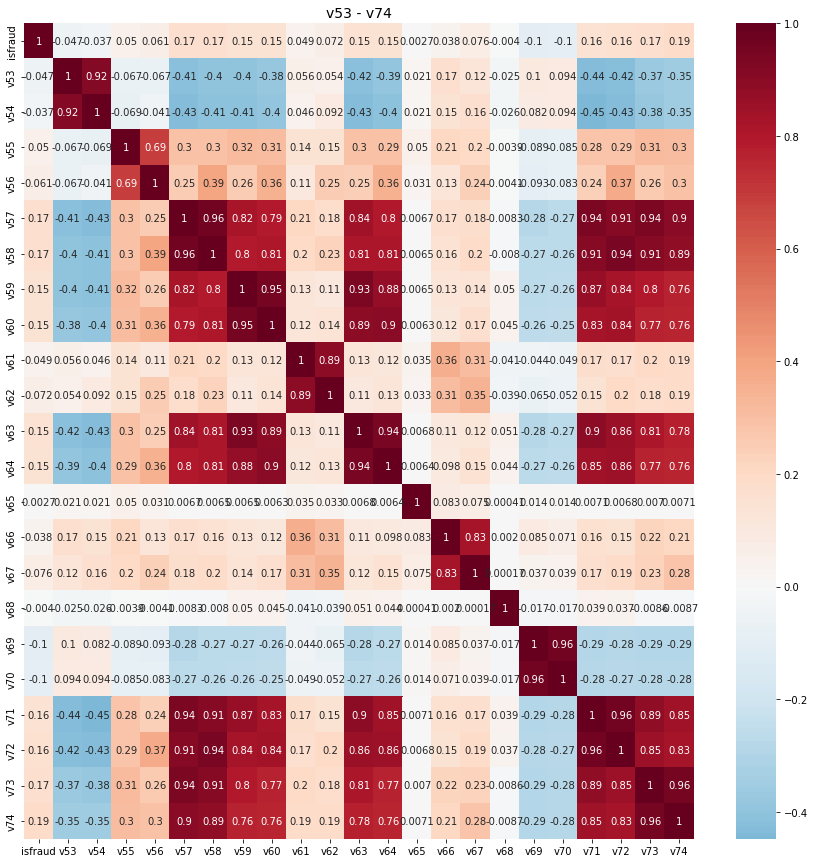

89164


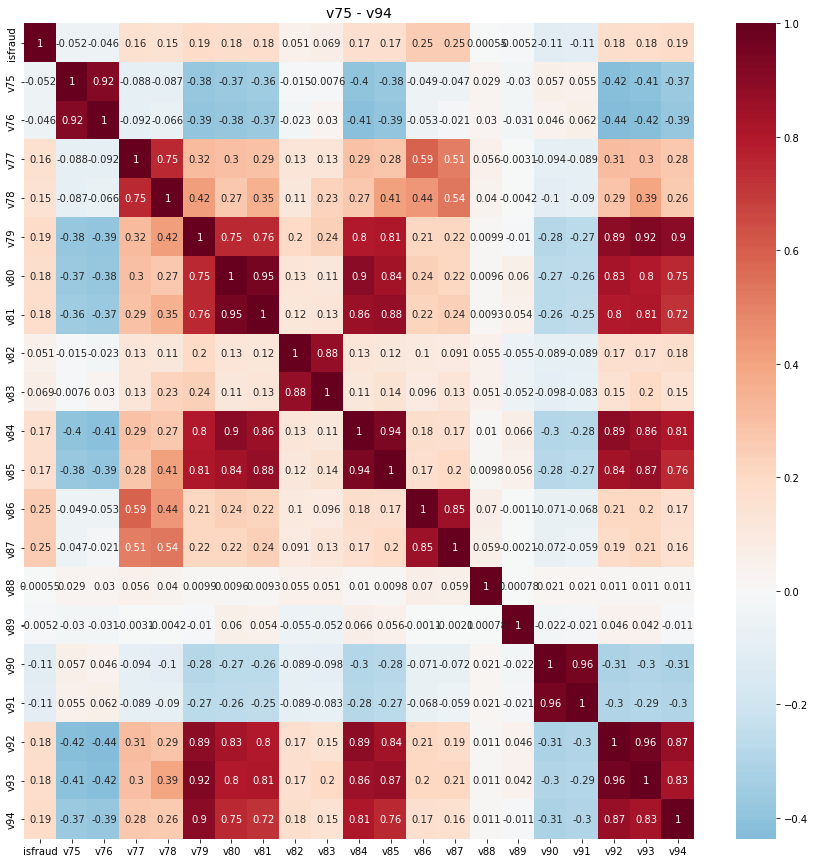

314


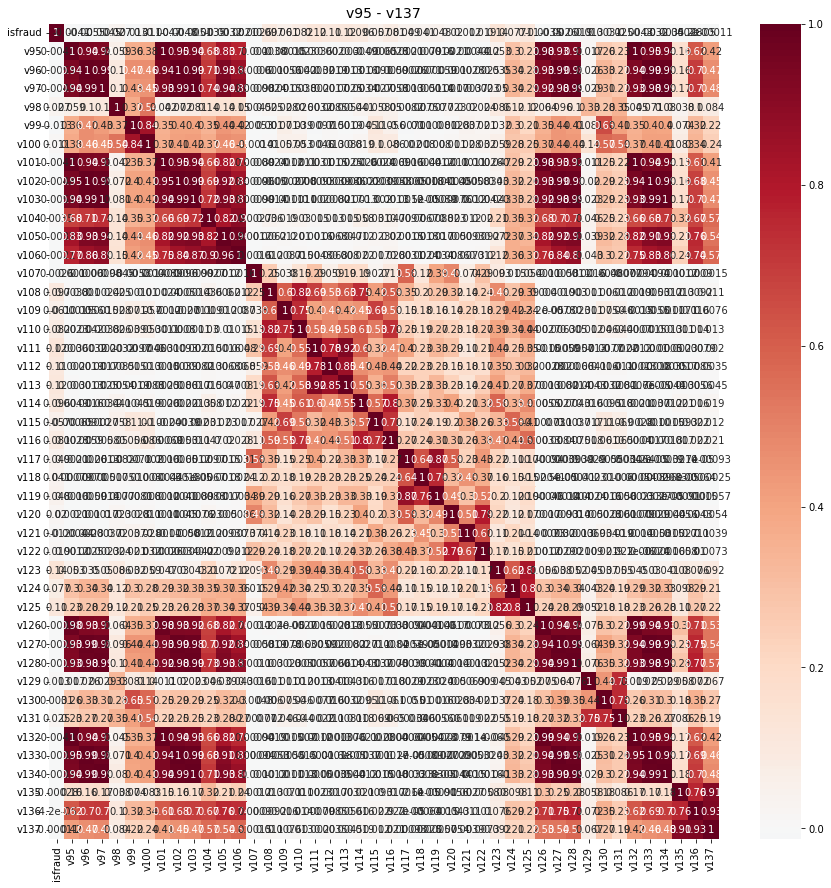

508595


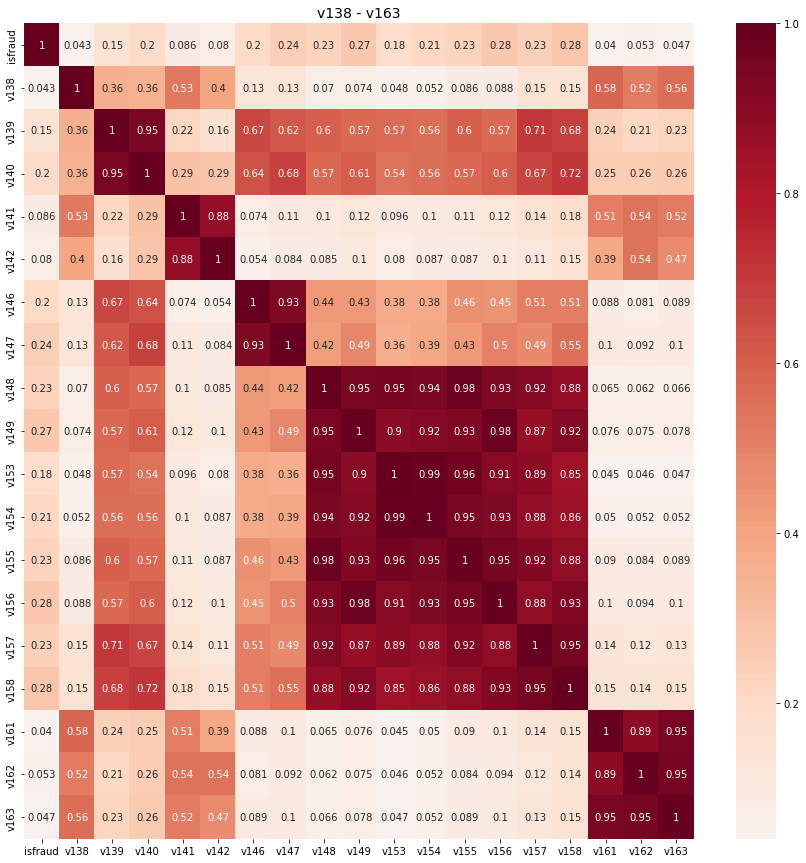

508589


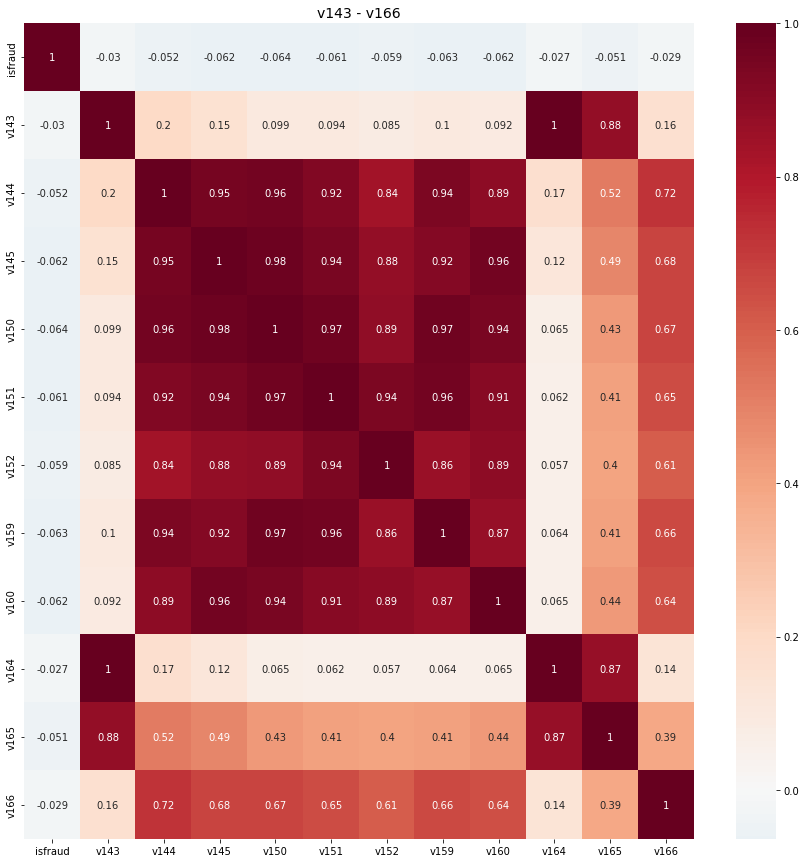

450909


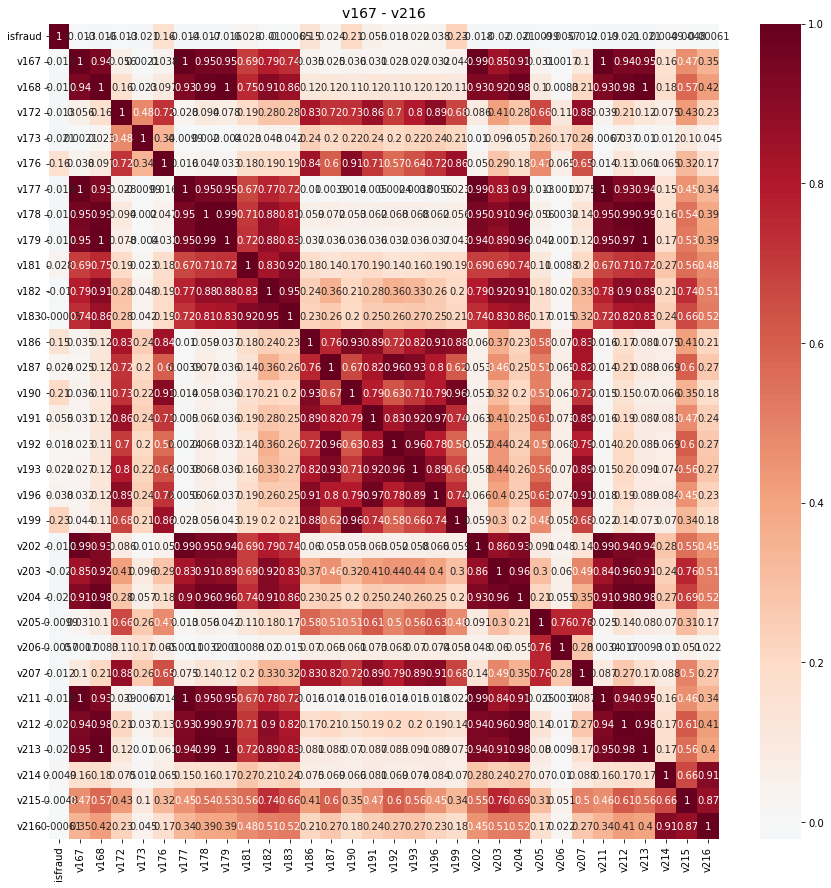

450721


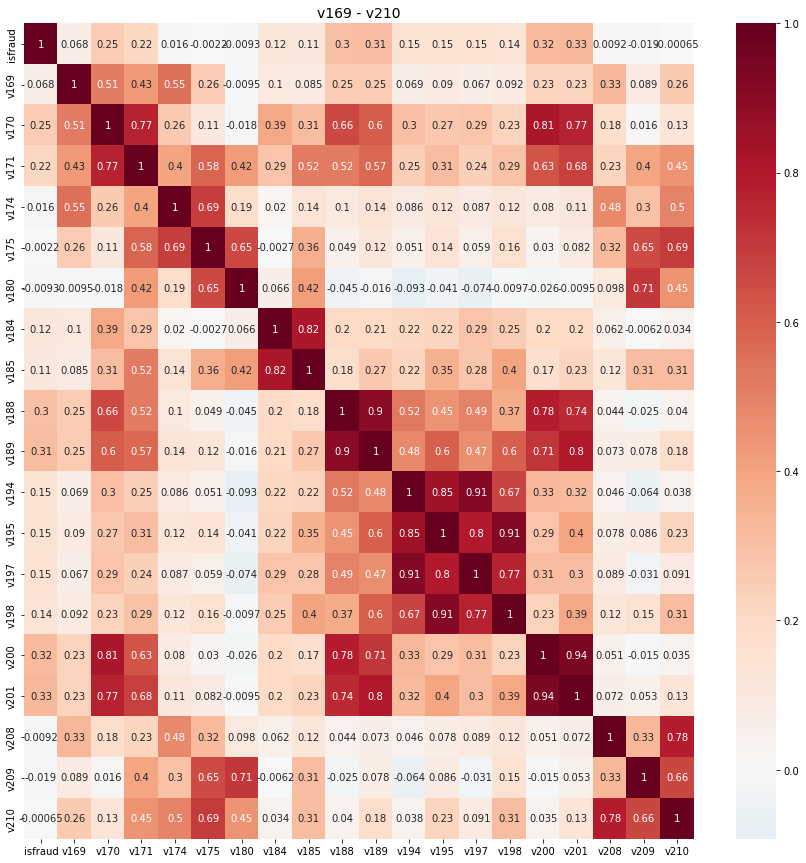

460110


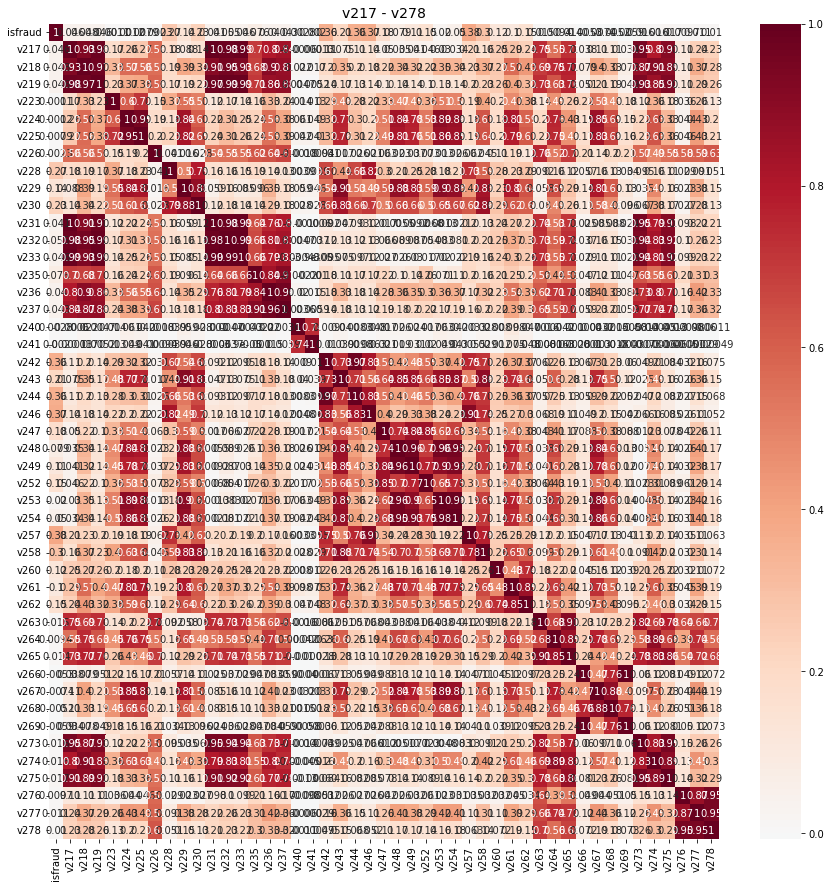

449124


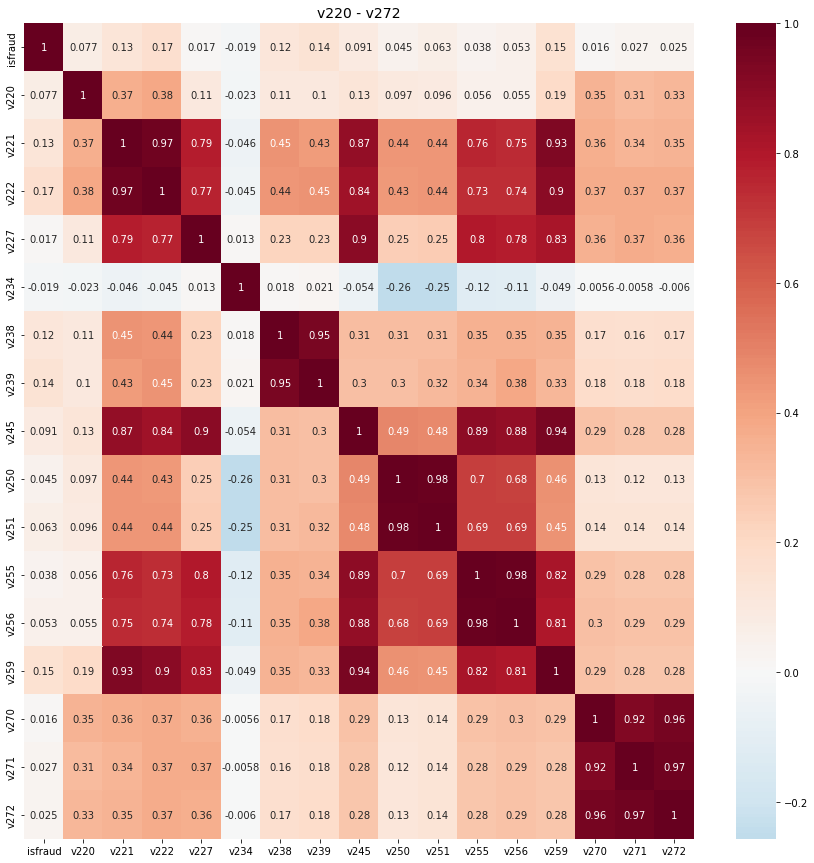

12


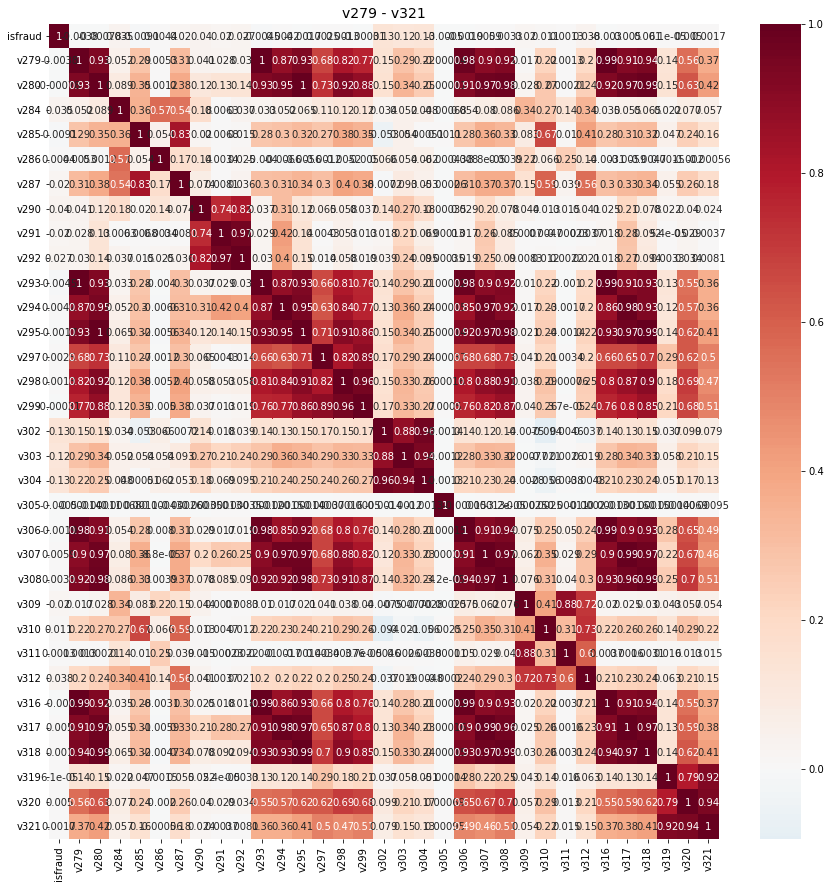

1269


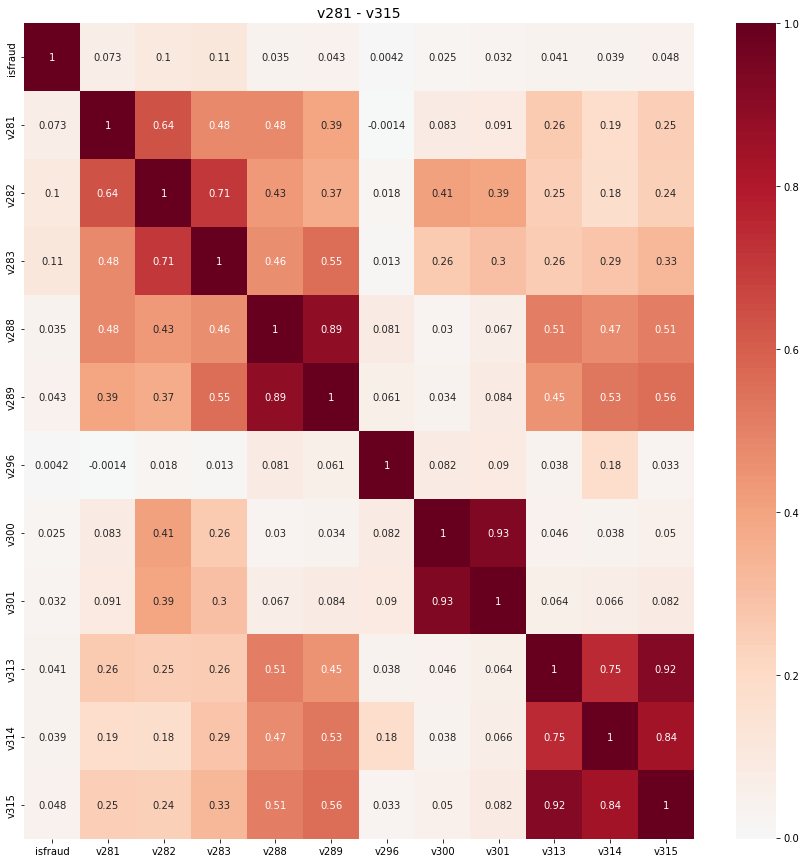

508189


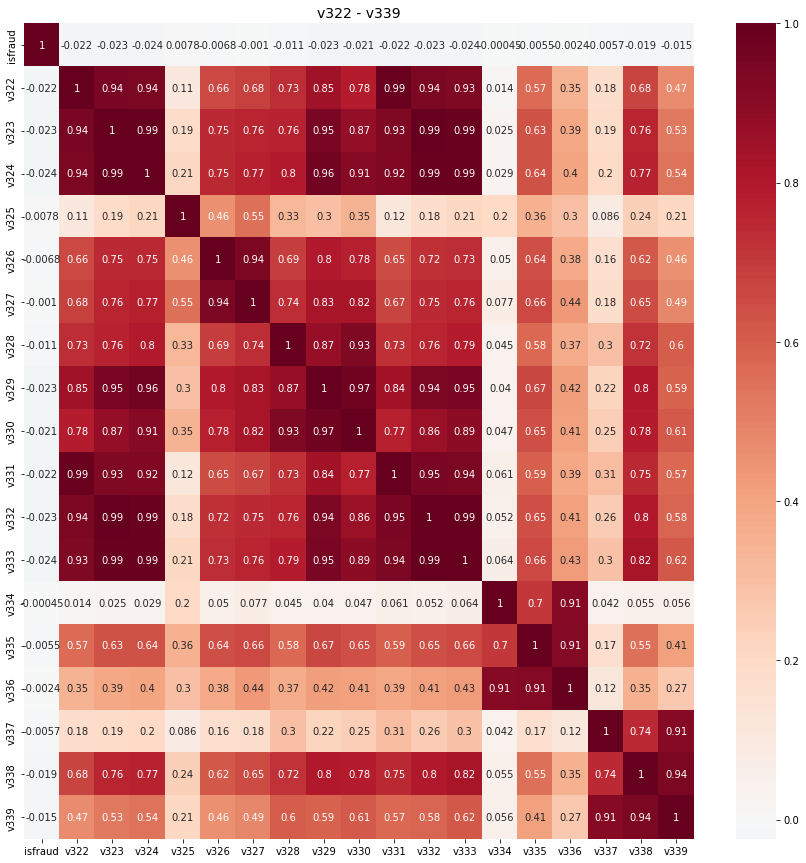

In [ ]:
#  chia V thành các nhóm có cùng NaN và vẽ correlation
a = v_processing_op_2(df_merge)
a

## II. MODELING

In [ ]:
def train_test_dt(df, size):
    y = df['isfraud']
    del df['isfraud']
    del df['transactionid']
    x = df
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    return x_train, x_test, y_train, y_test

class Model:
    def __init__(self, x_train, y_train, x_test, y_test):
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test

    def over_sampling(self):
        ros = RandomOverSampler(random_state=25)
        x_os, y_os = ros.fit_resample(self._x_train, self._y_train)
        return x_os, y_os

    def under_sampling(self):
        rus = RandomUnderSampler(random_state=42, replacement=True)
        x_us, y_us = rus.fit_resample(self._x_train, self._y_train)
        return x_us, y_us

    def smoothing(self):
        smote = SMOTE()
        x_smote, y_smote = smote.fit_resample(self._x_train, self._y_train)
        return x_smote, y_smote

    list_model = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]

    def modeling(self, list_model, x_tr,y_tr):
        result = {}
        for name, model in list_model:
            if name == 'random_forest':
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            elif name == 'Decision_tree':
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            else:
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            accuracy = round(accuracy_score(self._y_test, y_predict) * 100, 2)
            auc = round(roc_auc_score(self._y_test, y_prob) * 100, 2)
            f1 = round(f1_score(self._y_test, y_predict) * 100, 2)
            result[name] = {'auc': auc, 'accuracy': accuracy, 'f1_score': f1}

        result = pd.DataFrame(result)
        return result

# OPTION 1 : TEST USING PCA

In [ ]:
df2.head()

transactionid  isfraud  transactionamt  productcd  card4  dist1   c1   c3  \
0        2987000        0            68.5          1      4   19.0  1.0  0.0   
1        2987001        0            29.0          1      2    0.0  1.0  0.0   
2        2987002        0            59.0          1      1  287.0  1.0  0.0   
3        2987003        0            50.0          1      2    0.0  2.0  0.0   
4        2987004        0            50.0          2      2    0.0  1.0  0.0   

    c5   c13  ...  id_11  id_13  id_14  id_17  id_19  id_20  id_32  \
0  0.0   1.0  ...  -10.0  -90.0 -760.0    0.0    0.0    0.0 -100.0   
1  0.0   1.0  ...  -10.0  -90.0 -760.0    0.0    0.0    0.0 -100.0   
2  0.0   1.0  ...  -10.0  -90.0 -760.0    0.0    0.0    0.0 -100.0   
3  0.0  25.0  ...  -10.0  -90.0 -760.0    0.0    0.0    0.0 -100.0   
4  0.0   1.0  ...  100.0  -90.0 -480.0  166.0  542.0  144.0   32.0   

   devicetype_desktop  devicetype_mobile         pca_V0  
0                   1                  0   -6602.023002  
1                   1                  0   -6601.839604  
2                   1                  0   -6601.839665  
3                   1                  0   -6605.332678  
4                   0                  1  163765.385873  

[5 rows x 48 columns]

In [ ]:
df2.shape

(590540, 48)

In [ ]:
df_check_2 = df2
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_dt(df_check_2, size = 0.8)

In [ ]:
df_model_2 = Model(x_train_pca, y_train_pca, x_test_pca, y_test_pca)
list_model_2 = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]

In [ ]:
x_os_pca, y_os_pca = df_model_2.over_sampling()
result_os = df_model_2.modeling(list_model_2, x_tr = x_os_pca,y_tr = y_os_pca)
result_os

random_forest  Decision_tree   LGBM
auc               89.45          72.46  89.32
accuracy          96.46          94.37  86.89
f1_score          51.56          37.47  28.90

In [ ]:
x_us_pca, y_us_pca = df_model_2.under_sampling()
result_us = df_model_2.modeling(list_model_2, x_tr = x_us_pca,y_tr = y_us_pca)
result_us

random_forest  Decision_tree   LGBM
auc               88.04          80.90  88.64
accuracy          82.57          74.94  83.00
f1_score          23.81          17.27  24.42

In [ ]:
x_sm_pca, y_sm_pca = df_model_2.smoothing()
result_us = df_model_2.modeling(list_model_2, x_tr = x_sm_pca,y_tr = y_sm_pca)
result_us

random_forest  Decision_tree   LGBM
auc               87.90          75.83  86.10
accuracy          96.59          94.34  96.36
f1_score          47.43          35.34  43.57

# OPTION 2: TEST GROUP V_ COLUMNS

In [ ]:
detect_1 = Fraud_detection(df_merge)
df1 = detect_1.read_data()
df1 = detect_1.delete_null_over_p(p=90)
df1 = detect_1.delete_var_less_p(p=0.01)
df1 = detect_1.time_transaction()
df1 = detect_1.cleaning_personal_info()
df1 = detect_1.cleaning_distance()
df1 = detect_1.credit_card()
df1 = detect_1.processing_i()
df1 = detect_1.v_column()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
df_check_1 = df1
x_train, x_test, y_train, y_test = train_test_dt(df_check_1, size = 0.8)

In [ ]:
df1.shape

(590540, 126)

In [ ]:
df_model = Model(x_train, y_train, x_test, y_test)
list_model = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]


In [ ]:
x_os, y_os = df_model.over_sampling()
result_os = df_model.modeling(list_model, x_tr = x_os,y_tr = y_os)
result_os

random_forest  Decision_tree   LGBM
auc               89.81          72.08  89.89
accuracy          96.84          94.47  88.28
f1_score          54.18          37.43  31.13

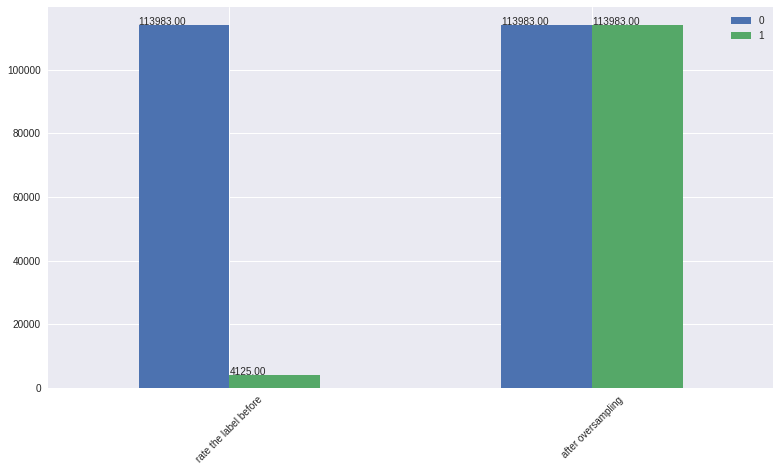

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
a = pd.DataFrame(y_train.value_counts())
b = pd.DataFrame(y_os.value_counts())
a['os'] = b 
a.columns = ['rate the label before','after oversampling']
a = a.T
ax = a.plot(kind = 'bar', figsize = (13,7))
for p in ax.patches: 
  width, height = p.get_width(), p.get_height()
  x,y = p.get_xy()
  ax.annotate('{:.2f}'.format(height), (x, y + height+0.02))
plt.xticks(rotation = 45)
plt.legend(a.columns, loc = 'upper right')

In [ ]:
x_us, y_us = df_model.under_sampling()
result_us = df_model.modeling(list_model, x_tr = x_us,y_tr = y_us)
result_us

random_forest  Decision_tree   LGBM
auc               88.48          80.93  89.37
accuracy          83.66          76.28  84.67
f1_score          24.91          18.14  26.31

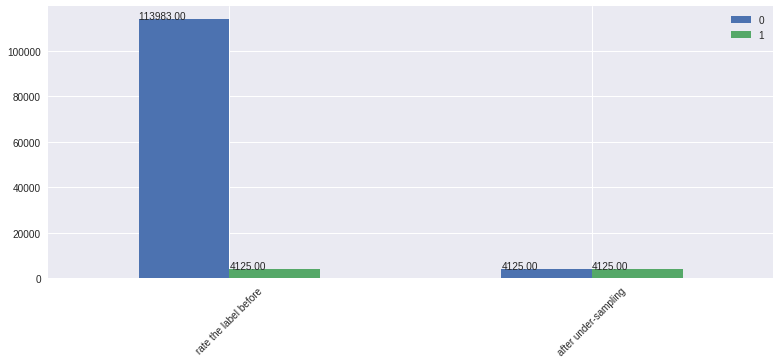

In [ ]:
# thêm 
a = pd.DataFrame(y_train.value_counts())
b = pd.DataFrame(y_us.value_counts())
a['us'] = b 
a.columns = ['rate the label before','after under-sampling']
a = a.T
ax = a.plot(kind = 'bar', figsize = (13,5))
for p in ax.patches: 
  width, height = p.get_width(), p.get_height()
  x,y = p.get_xy()
  ax.annotate('{:.2f}'.format(height), (x, y + height+0.02))
plt.xticks(rotation = 45)
plt.legend(a.columns, loc = 'upper right')

In [ ]:
x_sm, y_sm = df_model.smoothing()
result_us = df_model.modeling(list_model, x_tr = x_sm,y_tr = y_sm)
result_us

random_forest  Decision_tree   LGBM
auc               89.10          74.97  87.15
accuracy          97.41          95.76  97.25
f1_score          50.53          40.65  47.55

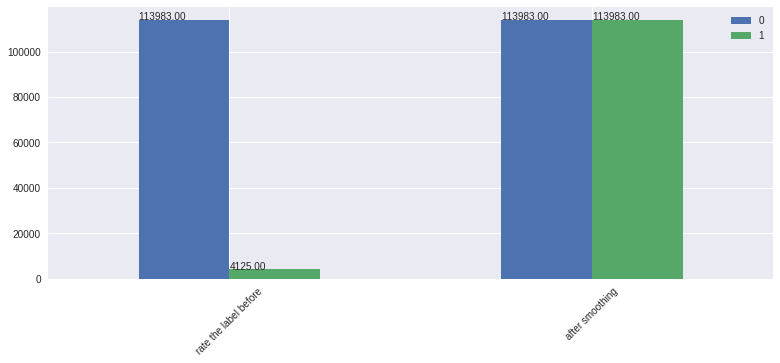

In [ ]:
# ............. Theem 
a = pd.DataFrame(y_train.value_counts())
b = pd.DataFrame(y_sm.value_counts())
a['sm'] = b 
a.columns = ['rate the label before','after smoothing']
a = a.T
ax = a.plot(kind = 'bar', figsize = (13,5))
for p in ax.patches: 
  width, height = p.get_width(), p.get_height()
  x,y = p.get_xy()
  ax.annotate('{:.2f}'.format(height), (x, y + height+0.02))
plt.xticks(rotation = 45)
plt.legend(a.columns, loc = 'upper right')

-> Conclutions: với option1, auc và accuracy được cải thiện nhiều hơn so với option2 : giảm chiều pca 
Bởi lẽ: tại options 1 chúng tôi giữ lại được nhiều features quan trọng hơn so với option 2 

## III. RESULT AND VISUALIZE

In [ ]:
# -> Chọn model LBGM , với pp oversampling
class Visualize_result:
    def __init__(self, model, x_train, y_train, x_test, y_test):
        self._model = model
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test

    def class_report(self):
        clf = self._model.fit(self._x_train, self._y_train)
        y_predict = clf.predict(self._x_test)
        y_predict_proba = clf.predict_proba(self._x_test)[:, 1]
        print("AUC", round(roc_auc_score(self._y_test, y_predict_proba) * 100, 2))
        print('Classification_Accuracy',round(accuracy_score(self._y_test, y_predict)*100,2))
        print('Recall',round(recall_score(self._y_test,y_predict)*100,2))
        print('Precision',round(precision_score(self._y_test, y_predict)*100,2))
      
        features_importance = pd.DataFrame(sorted(zip(clf.feature_importances_, self._x_train.columns)), columns = ['value', 'Features'])
        sorted_df= features_importance.sort_values(by = 'value', ascending = False)
        sorted_df = sorted_df.head(n=10)
        plt.figure(figsize=(20, 10))
        sns.barplot(x="value", y="Features", data= sorted_df)
        plt.show()
        return None

    def confusion_auc(self):
        clf = self._model.fit(self._x_train, self._y_train)
        y_prob = clf.predict_proba(self._x_test)[:, 1]
        # confusion matrix
        # roc graph
        fpr, tpr, threshold = roc_curve(y_test, y_prob)
        # roc_auc = auc(fpr, tpr)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label="AUC = " + str(auc))
        plt.plot(fpr, tpr, color="yellow", lw=2, label="AUC area = " + str(auc))
        plt.xlabel(" True Positive Rate ")
        plt.ylabel(" False Positive Rate ")
        plt.legend(loc=4)
        # 
        ax2 = plot_confusion_matrix(clf,self._x_test, self._y_test)
        plt.show()
        return None

AUC 89.81
Classification_Accuracy 96.84
Recall 53.36
Precision 55.03


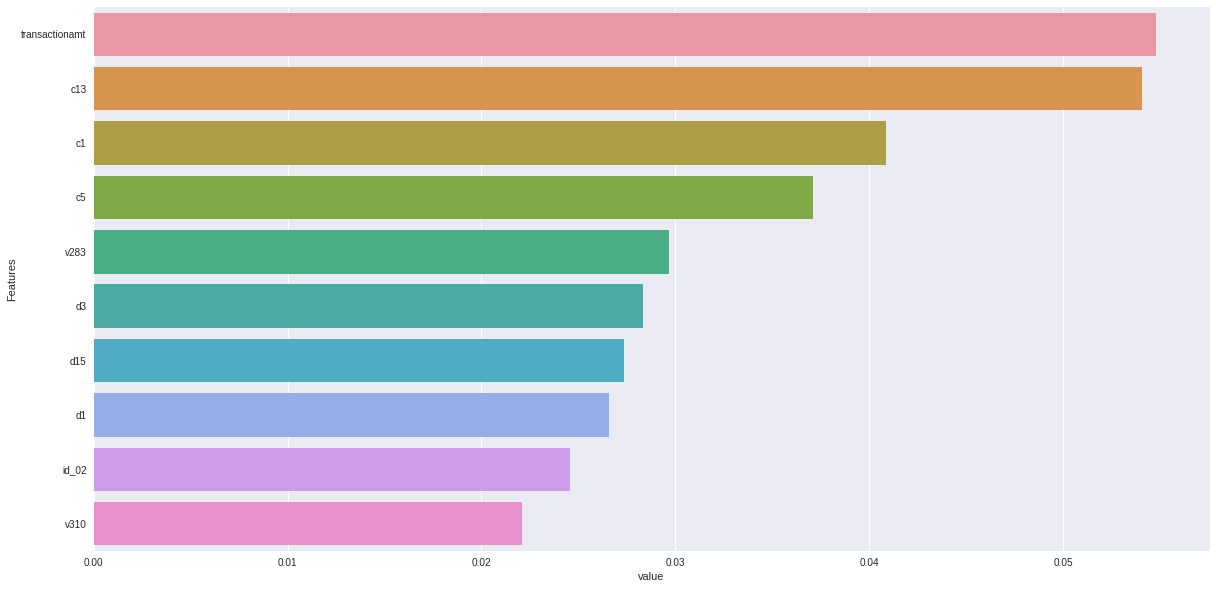

In [ ]:
ax1 = Visualize_result(RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5),\
                      x_train = x_os, y_train = y_os, x_test = x_test, y_test = y_test)
final_result = ax1.class_report()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


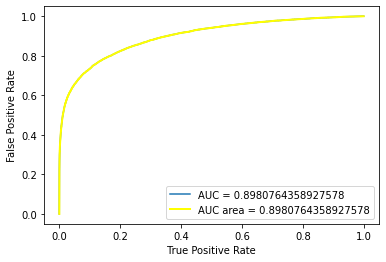

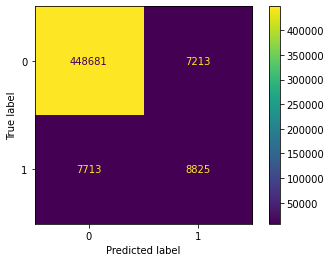

In [ ]:
final_result = ax1.confusion_auc()

AUC 89.89
Classification_Accuracy 88.28
Recall 75.68
Precision 19.6


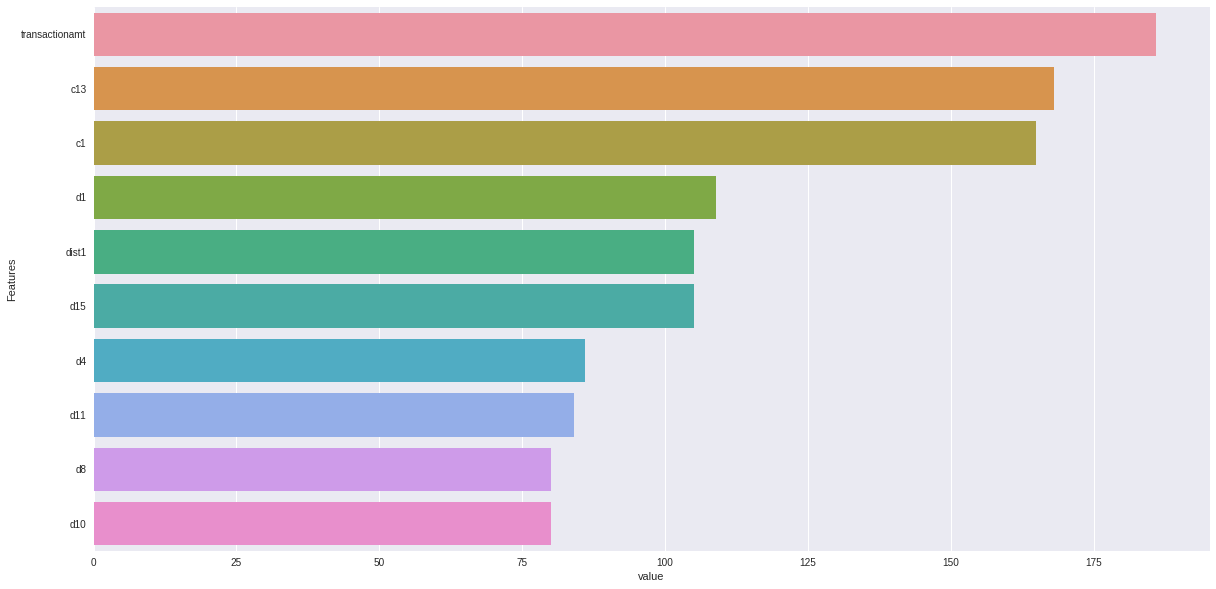

In [ ]:
#  2 mô hình được lựa chọn là: random forest và lighGBM
#  với model random forest: tỉ lệ nhãn 1 dự đoán thành nhãn 0 đang chiếm số lượng nhiều hơn so với model lightGBM -> nên để lựa chọn đảm bảo các khoản rủi ro 
#  ta chọn model lightGBM
ax2 = Visualize_result(lgb.LGBMClassifier(),\
                      x_train = x_os, y_train = y_os, x_test = x_test, y_test = y_test)
final_result = ax2.class_report()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


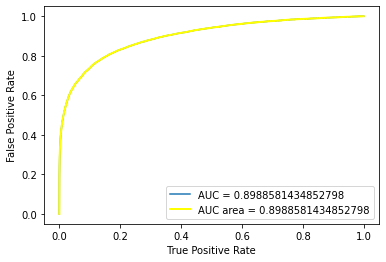

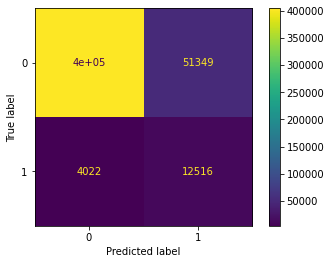

In [ ]:
final_result = ax2.confusion_auc()

# IMPROVING MODEL

In [ ]:
#  randomforest using oversampling
#  grid search CV 
# min_child_samples = [5,10,15] -> choose : 10
# num_leaves = [50,100,200] -> choose: 200
from sklearn.model_selection import GridSearchCV
lgb = lgb.LGBMClassifier()
parameters = {'num_leaves': [100,200],'min_child_samples': [5,10], 'reg_alpha': [0,0.01]}
clf = GridSearchCV(lgb, parameters, scoring = 'accuracy')
clf.fit(X = x_os, y = y_os)
print(clf.best_params_)
# predicted = clf.predict(x_test)

{'min_child_samples': 10, 'num_leaves': 200, 'reg_alpha': 0}


In [ ]:
predicted = clf.predict(x_test)

In [ ]:
y_predict_proba = clf.predict_proba(x_test)[:, 1]
target_names = ["Class 0", "Class 1"]
print("AUC", round(roc_auc_score(y_test, y_predict_proba) * 100, 2))
print(classification_report(y_test, predicted, target_names=target_names))

AUC 90.21
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98    455894
     Class 1       0.42      0.64      0.50     16538

    accuracy                           0.96    472432
   macro avg       0.70      0.80      0.74    472432
weighted avg       0.97      0.96      0.96    472432



In [ ]:
a = confusion_matrix(y_test, predicted)
a = pd.DataFrame(a, index =[0,1] )
a

0      1
0  441014  14880
1    5933  10605

-> After selecting the LightGBM model, we use the Grid Search CV algorithm to find the
right parameters for the model with the aim of improving the speed and performance of the
model.
- We found that the AUC and the coefficients of class 1 improved, besides the True
Negative score was significantly improved for a better customer experience.
